In [1]:
%pylab inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
koubei = pd.read_csv(
    'data/ijcai2016_koubei_train', header=None, names=['user_id', 'merchant_id', 'location_id', 'timestamp']
)

In [4]:
pred = pd.read_csv('data/ijcai2016_koubei_test', header=None, names=['user_id', 'location_id'])

In [5]:
merchant = pd.read_csv('data/ijcai2016_merchant_info', header=None, names=['merchant_id', 'budget', 'locations'])

# 生成测试数据

这里只取“预测集”里的和之前月份取交集的用户作为测试。因为给定的集合实际上由**线上、线下**两部分组成，因此，很难组合出和实际预测集相近的验证集。这样的话，虽然和实际情况并不相符，但是可以理解整个计算过程。

取 7 月份口碑的用户行为记录

In [18]:
koubei7 = koubei[koubei.timestamp.between(20150701, 20150731)]

取 8 月份的口碑记录

In [15]:
koubei8 = koubei[koubei.timestamp.between(20150801, 20150831)]

取 9 月份的口碑记录

In [13]:
koubei9 = koubei[koubei.timestamp.between(20150901, 20150930)]

取 10 月份的口碑记录

In [6]:
koubei10 = koubei[koubei.timestamp.between(20151001, 20151031)]

取 11 月份的口碑记录

In [7]:
koubei11 = koubei[koubei.timestamp.between(20151101, 20151131)]

# 统计新老客户的占比

新老用户在各个月份的占比，对应到其测评的准确率、召回率是否具有一定的影响，以及相互间的关系。

In [37]:
print('Jul. no. of users: %d' % (koubei7.user_id.nunique()))
print('Aug. no. of users: %d' % (koubei8.user_id.nunique()))
print('Old users in Nov.: %d (%.2f%%)' % (
    koubei8[koubei8.user_id.isin(koubei7.user_id)].user_id.nunique(),
    koubei8[koubei8.user_id.isin(koubei7.user_id)].user_id.nunique() / float(koubei8.user_id.nunique()) * 100
))

Jul. no. of users: 11145
Aug. no. of users: 24386
Old users in Nov.: 3665 (15.03%)


In [16]:
print('Aug. no. of users: %d' % (koubei8.user_id.nunique()))
print('Sep. no. of users: %d' % (koubei9.user_id.nunique()))
print('Old users in Nov.: %d (%.2f%%)' % (
    koubei9[koubei9.user_id.isin(koubei8.user_id)].user_id.nunique(),
    koubei9[koubei9.user_id.isin(koubei8.user_id)].user_id.nunique() / float(koubei9.user_id.nunique()) * 100
))

Aug. no. of users: 24386
Sep. no. of users: 42783
Old users in Nov.: 10846 (25.35%)


In [14]:
print('Sep. no. of users: %d' % (koubei9.user_id.nunique()))
print('Oct. no. of users: %d' % (koubei10.user_id.nunique()))
print('Old users in Nov.: %d (%.2f%%)' % (
    koubei10[koubei10.user_id.isin(koubei9.user_id)].user_id.nunique(),
    koubei10[koubei10.user_id.isin(koubei9.user_id)].user_id.nunique() / float(koubei10.user_id.nunique()) * 100
))

Sep. no. of users: 42783
Oct. no. of users: 116413
Old users in Nov.: 24785 (21.29%)


In [8]:
print('Oct. no. of users: %d' % (koubei10.user_id.nunique()))
print('Nov. no. of users: %d' % (koubei11.user_id.nunique()))
print('Old users in Nov.: %d (%.2f%%)' % (
    koubei11[koubei11.user_id.isin(koubei10.user_id)].user_id.nunique(),
    koubei11[koubei11.user_id.isin(koubei10.user_id)].user_id.nunique() / float(koubei11.user_id.nunique()) * 100
))

Oct. no. of users: 116413
Nov. no. of users: 158544
Old users in Nov.: 67522 (42.59%)


In [9]:
print('Nov. no. of users: %d' % (koubei11.user_id.nunique()))
print('Dec. no. of users: %d' % (pred.user_id.nunique()))
print('Old users in Dec.: %d (%.2f%%)' % (
    pred[pred.user_id.isin(koubei11.user_id)].user_id.nunique(),
    pred[pred.user_id.isin(koubei11.user_id)].user_id.nunique() / float(pred.user_id.nunique()) * 100
))

Nov. no. of users: 158544
Dec. no. of users: 465366
Old users in Dec.: 37838 (8.13%)


In [10]:
print('Jul.~Nov. no. of users: %d' % (koubei.user_id.nunique()))
print('Dec. no. of users: %d' % (pred.user_id.nunique()))
print('Old users in Dec.: %d (%.2f%%)' % (
    pred[pred.user_id.isin(koubei.user_id)].user_id.nunique(),
    pred[pred.user_id.isin(koubei.user_id)].user_id.nunique() / float(pred.user_id.nunique()) * 100
))

Jul.~Nov. no. of users: 230496
Dec. no. of users: 465366
Old users in Dec.: 50487 (10.85%)


# 老客户回购预测

计算 10 月预测 11 月的 F1 值。

In [11]:
def evaluate(pset, aset):
    ''' 
    pset is the predicted set.
    aset is the actual set.
    '''
    pset = pset[['user_id', 'location_id', 'merchant_id']].drop_duplicates()
    aset = aset[['user_id', 'location_id', 'merchant_id']].drop_duplicates()
    pset = pd.merge(pset, aset[['user_id', 'location_id']], on=['user_id', 'location_id'], how='inner')
    hit = pd.merge(aset, pset, on=['user_id', 'location_id', 'merchant_id'], how="inner").drop_duplicates()
    a = pd.merge(
        merchant[['merchant_id', 'budget']],
        hit.groupby('merchant_id').user_id.count().reset_index(),
        on='merchant_id', how='inner'
    ).apply(lambda d: min(d['budget'], d['user_id']), axis=1).sum()
    b = pd.merge(
        merchant[['merchant_id', 'budget']],
        aset.groupby('merchant_id').user_id.count().reset_index(),
        on='merchant_id', how='inner'
    ).apply(lambda d: min(d['budget'], d['user_id']), axis=1).sum()
    c = pset.groupby('merchant_id').user_id.count().sum()
    print a, b, c
    p = a / float(c)
    r = a / float(b)
    print('Predict: %.2f%%' % (p * 100))
    print('Recall: %.2f%%'  % (r * 100))
    return 2 * p * r / (p + r)

测试 7 月预测 8 月的测评。

In [22]:
evaluate(koubei7, koubei8)

3100 26571 4542
Predict: 68.25%
Recall: 11.67%


0.19927361553048567

测试 8 月预测 9 月的测评。

In [21]:
evaluate(koubei8, koubei9)

9602 46222 13538
Predict: 70.93%
Recall: 20.77%


0.32135207496653284

测试 9 月预测 10 月的测评。

In [20]:
evaluate(koubei9, koubei10)

21447 114362 33581
Predict: 63.87%
Recall: 18.75%


0.2899359888605747

测试 10 月预测 11 月的测评。

In [12]:
evaluate(koubei10, koubei11)

52274 161186 110218
Predict: 47.43%
Recall: 32.43%


0.3852117139025217

使用 11 月以前的用户行为记录对 11 月的数据进行测评。

In [86]:
evaluate(
    koubei[koubei.timestamp.between(20150701, 20151031)],
    koubei11
)

57818 161186 130119
Predict: 44.43%
Recall: 35.87%


0.3969585142719829

# 分析

由于在 pred 集合中，使用 12 月以前的数据进行测评，得到的 F1 值相在 16% 左右。



从预测的 F1 值反推，目前可能的方案是：

Prediction | Recall | F1
-----------|--------|-----
0.1 | 0.1 | 0.1
0.1 | 0.2 | 0.133
0.1 | 0.3 | 0.15
0.1 | 0.4 | 0.160
0.1 | 0.5 | 0.166
0.1 | 0.6 | 0.17
0.1 | 1.0 | 0.18
0.2 | 0.2 | 0.2

在纯口碑数据集看来，召回最高也才 35% 左右，而预测数据集包括不少新用户。在提交第一次提交时，取的是 11 月的样本，召回率应该在 30% 以下，如果假设是 20% ，那么对应的准确率是 10% 。

目前在线测评得到的 F1 值和 7 月测 8 月的数值规模类似，而与其他月份差距相当大，这里存在以下假设：

1. 给定的预测集里并非所有用户都有购买行为；
2. 给定的训练集的样本太小，导致；
3. 11 月份的数据有异常，由于双十一被剔除，导致 11 月的数据是不完整的，这段时间可能存在大量新客户，因此 10 月预测 11 月的数据是不靠谱的；
4. 12 月的数据有异常，12 月只剔除了“双十二”数据，实际上“双十二”影响的时间段要比这个长。

In [23]:
from datetime import datetime as dt

In [26]:
koubei['ts'] = koubei.timestamp.map(lambda d: dt.strptime(str(d), '%Y%m%d'))
koubei['month'] = koubei.ts.map(lambda d: d.strftime('%m'))
koubei['day'] = koubei.ts.map(lambda d: d.strftime('%d'))

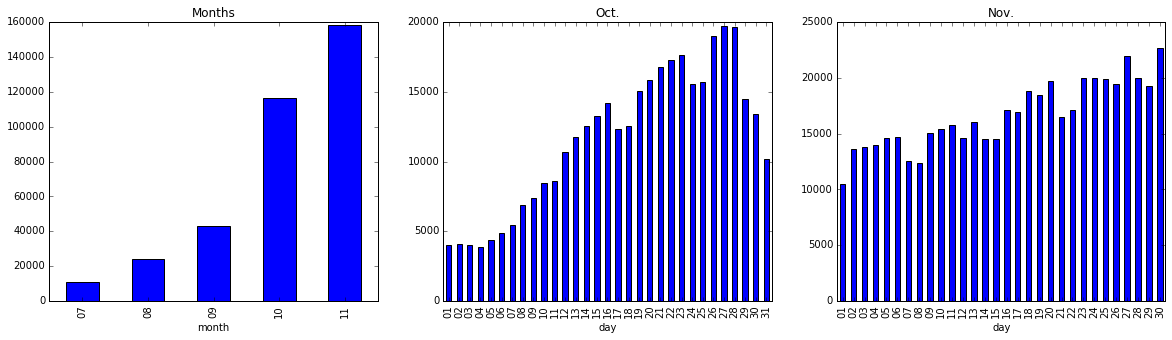

In [36]:
subplot(131); koubei.groupby('month').user_id.nunique().plot.bar(title='Months');
subplot(132); koubei[koubei.timestamp.between(20151001, 20151031)].groupby('day').user_id.nunique().plot.bar(figsize=(20, 5), title='Oct.');
subplot(133); koubei[koubei.timestamp.between(20151101, 20151131)].groupby('day').user_id.nunique().plot.bar(figsize=(20, 5), title='Nov.');

-------

由此可见，11 月的数据实际上问题并不大。注意到口碑网在 2015 年 6 月重启，这个时候的口碑网用户十分少，新用户激增，从 7 月的老用户只占到 15% 。在 2015 年 10 月左右整合进支付宝的，这个时间里带来了大量的新用户。

基本可以得出两个结论：

1. 给定的训练集的样本太小，基本没有淘宝中转化的 → 要挖掘这部分用户依靠这部分数据的作用可能很有限；
2. 预测准确率并没有以前想的那么高，只有大概 60% 。

由此可以推出之前的**预测准确率并没有那么高，反而召回率比较高**，因此，增加热门地点搜索以后对拉高召回率帮助不大，而准确率上下降太多了。